<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_2_Convolution_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import os

# Download Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asadullahgalib/guava-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/guava-disease-dataset


In [3]:
ds_folder = path+"/GuavaDiseaseDataset/GuavaDiseaseDataset/"

In [4]:
img_size = (224, 224)
img_channels = 3
batch_size = 64
lr = 1e-3

# Datasets and DataLoaders

In [5]:
train_dataset = ImageFolder(root=ds_folder + "train/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.RandomHorizontalFlip(0.5),
                                T.RandomVerticalFlip(0.5),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [6]:
test_dataset = ImageFolder(root=ds_folder + "test/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [7]:
val_dataset = ImageFolder(root=ds_folder + "val/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [8]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [9]:
os.makedirs("Models", exist_ok=True)

# Training Functins

In [10]:
def train_step(model, data_loader, criterion, optimizer, scheduler):

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Training")
  total_loss = 0.0
  total_correct = 0.0

  model.train()

  for image, label in progress_bar:
    images, labels = image.cuda(), label.cuda()

    optimizer.zero_grad()

    predictions = model(images)
    predicted_classes = torch.argmax(predictions, dim=1)
    correct_classes = torch.sum(predicted_classes == labels)
    loss = criterion(predictions, labels)

    total_correct += correct_classes.item()
    total_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
    optimizer.step()
  scheduler.step(loss.item())

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [11]:
def evaluate(model, data_loader, criterion):

  model.eval()

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Evaluating")
  total_loss = 0.0
  total_correct = 0.0

  with torch.no_grad():

    for image, label in progress_bar:
      images, labels = image.cuda(), label.cuda()

      predictions = model(images)
      predicted_classes = torch.argmax(predictions, dim=1)
      correct_classes = torch.sum(predicted_classes == labels)
      loss = criterion(predictions, labels)

      total_correct += correct_classes.item()
      total_loss += loss.item()

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [12]:
def fit(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs, experiment_name):

  df = pd.DataFrame(np.empty([epochs, 5]),
                    index=np.arange(epochs),
                    columns=["Train_Loss", "Train_Acc", "Val_Loss", "Val_Acc", "lr"])

  highest_acc = 0.00

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    df.iloc[epoch, 0], df.iloc[epoch, 1] = train_step(model=model, data_loader=train_dataloader,
                                            criterion=criterion, optimizer=optimizer,
                                            scheduler=scheduler)

    df.iloc[epoch, 2], df.iloc[epoch, 3] = evaluate(model=model, data_loader=val_dataloader,
                                            criterion=criterion)

    df.iloc[epoch, 4] = optimizer.param_groups[0]["lr"]

    print(f"Training Loss = {df.iloc[epoch, 0]:.7f}, Training Accuracy = {df.iloc[epoch, 1]:.3f}\nTesting Loss = {df.iloc[epoch, 2]:.7f}, Testing Accuracy = {df.iloc[epoch, 3]:.3f}")


    if df.iloc[epoch, 3] > highest_acc:
      torch.save(model.state_dict(), f"Models/{experiment_name}.pth")
      highest_acc = df.iloc[epoch, 3]
      print(f"New best accuracy: {highest_acc:.3f} at epoch {epoch+1}")

    print("*"*50)
    print("")

  return df

# FC Neural Network

In [13]:
class FC_Model(nn.Module):
  def __init__(self, skeleton:list, num_classes):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.Dropout1d(0.5))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], num_classes))
    self.model = nn.Sequential(*layer_list)

  def forward(self, images):
    inputs = images.view(images.shape[0], -1)
    output = self.model(inputs)
    return output

In [14]:
model = FC_Model(skeleton=[img_size[0]*img_size[1]*3, 100, 50, 20], num_classes=3).cuda()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [16]:
fc_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="fully_connected")

Epoch 1


Evaluating: 100%|██████████| 76/76 [00:12<00:00,  5.88it/s]


Training Loss = 0.0177405, Training Accuracy = 37.061
Testing Loss = 0.1026933, Testing Accuracy = 41.192
New best accuracy: 41.192 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Training Loss = 0.0166419, Training Accuracy = 40.348
Testing Loss = 0.1032710, Testing Accuracy = 38.808
**************************************************

Epoch 3


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.06it/s]


Training Loss = 0.0164198, Training Accuracy = 41.519
Testing Loss = 0.1002177, Testing Accuracy = 48.344
New best accuracy: 48.344 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.91it/s]


Training Loss = 0.0162561, Training Accuracy = 42.199
Testing Loss = 0.0987521, Testing Accuracy = 59.735
New best accuracy: 59.735 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.66it/s]


Training Loss = 0.0162600, Training Accuracy = 42.539
Testing Loss = 0.0954883, Testing Accuracy = 62.517
New best accuracy: 62.517 at epoch 5
**************************************************

Epoch 6


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.98it/s]


Training Loss = 0.0162934, Training Accuracy = 42.199
Testing Loss = 0.0952042, Testing Accuracy = 67.417
New best accuracy: 67.417 at epoch 6
**************************************************

Epoch 7


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.00it/s]


Training Loss = 0.0162251, Training Accuracy = 41.556
Testing Loss = 0.0943905, Testing Accuracy = 72.583
New best accuracy: 72.583 at epoch 7
**************************************************

Epoch 8


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Training Loss = 0.0161556, Training Accuracy = 42.803
Testing Loss = 0.0946250, Testing Accuracy = 71.656
**************************************************

Epoch 9


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.63it/s]


Training Loss = 0.0159824, Training Accuracy = 43.634
Testing Loss = 0.0949526, Testing Accuracy = 72.053
**************************************************

Epoch 10


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.92it/s]


Training Loss = 0.0158497, Training Accuracy = 42.803
Testing Loss = 0.0923590, Testing Accuracy = 74.834
New best accuracy: 74.834 at epoch 10
**************************************************

Epoch 11


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.15it/s]


Training Loss = 0.0159012, Training Accuracy = 43.672
Testing Loss = 0.0910529, Testing Accuracy = 75.232
New best accuracy: 75.232 at epoch 11
**************************************************

Epoch 12


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.10it/s]


Training Loss = 0.0157631, Training Accuracy = 44.352
Testing Loss = 0.0904733, Testing Accuracy = 74.967
**************************************************

Epoch 13


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.16it/s]


Training Loss = 0.0159519, Training Accuracy = 42.463
Testing Loss = 0.0877058, Testing Accuracy = 77.086
New best accuracy: 77.086 at epoch 13
**************************************************

Epoch 14


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.87it/s]


Training Loss = 0.0158580, Training Accuracy = 43.597
Testing Loss = 0.0895390, Testing Accuracy = 75.232
**************************************************

Epoch 15


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.09it/s]


Training Loss = 0.0157541, Training Accuracy = 44.012
Testing Loss = 0.0892305, Testing Accuracy = 75.497
**************************************************

Epoch 16


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.04it/s]


Training Loss = 0.0157275, Training Accuracy = 44.239
Testing Loss = 0.0901266, Testing Accuracy = 75.232
**************************************************

Epoch 17


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.21it/s]


Training Loss = 0.0156103, Training Accuracy = 45.825
Testing Loss = 0.0902716, Testing Accuracy = 74.305
**************************************************

Epoch 18


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.53it/s]


Training Loss = 0.0156843, Training Accuracy = 46.128
Testing Loss = 0.0896209, Testing Accuracy = 75.232
**************************************************

Epoch 19


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  8.41it/s]


Training Loss = 0.0156569, Training Accuracy = 46.543
Testing Loss = 0.0886230, Testing Accuracy = 76.291
**************************************************

Epoch 20


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.88it/s]


Training Loss = 0.0155424, Training Accuracy = 47.223
Testing Loss = 0.0903967, Testing Accuracy = 75.497
**************************************************

Epoch 21


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.93it/s]


Training Loss = 0.0156319, Training Accuracy = 47.299
Testing Loss = 0.0886082, Testing Accuracy = 76.026
**************************************************

Epoch 22


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.94it/s]


Training Loss = 0.0155037, Training Accuracy = 47.828
Testing Loss = 0.0877749, Testing Accuracy = 76.291
**************************************************

Epoch 23


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.75it/s]


Training Loss = 0.0156416, Training Accuracy = 46.619
Testing Loss = 0.0891428, Testing Accuracy = 75.762
**************************************************

Epoch 24


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.00it/s]


Training Loss = 0.0156722, Training Accuracy = 46.128
Testing Loss = 0.0880190, Testing Accuracy = 77.881
New best accuracy: 77.881 at epoch 24
**************************************************

Epoch 25


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Training Loss = 0.0157554, Training Accuracy = 46.657
Testing Loss = 0.0877518, Testing Accuracy = 76.424
**************************************************

Epoch 26


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.71it/s]


Training Loss = 0.0156021, Training Accuracy = 46.959
Testing Loss = 0.0883233, Testing Accuracy = 76.159
**************************************************

Epoch 27


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.70it/s]


Training Loss = 0.0156672, Training Accuracy = 46.241
Testing Loss = 0.0877439, Testing Accuracy = 74.967
**************************************************

Epoch 28


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.99it/s]


Training Loss = 0.0156547, Training Accuracy = 46.090
Testing Loss = 0.0873535, Testing Accuracy = 75.762
**************************************************

Epoch 29


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.11it/s]


Training Loss = 0.0155284, Training Accuracy = 47.601
Testing Loss = 0.0879545, Testing Accuracy = 76.291
**************************************************

Epoch 30


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.99it/s]


Training Loss = 0.0155462, Training Accuracy = 47.488
Testing Loss = 0.0877391, Testing Accuracy = 76.556
**************************************************

Epoch 31


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.08it/s]


Training Loss = 0.0154988, Training Accuracy = 47.903
Testing Loss = 0.0879007, Testing Accuracy = 75.762
**************************************************

Epoch 32


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Training Loss = 0.0155151, Training Accuracy = 47.337
Testing Loss = 0.0852735, Testing Accuracy = 78.278
New best accuracy: 78.278 at epoch 32
**************************************************

Epoch 33


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.13it/s]


Training Loss = 0.0155573, Training Accuracy = 46.241
Testing Loss = 0.0858320, Testing Accuracy = 78.808
New best accuracy: 78.808 at epoch 33
**************************************************

Epoch 34


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.93it/s]


Training Loss = 0.0153987, Training Accuracy = 47.639
Testing Loss = 0.0872990, Testing Accuracy = 75.762
**************************************************

Epoch 35


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.08it/s]


Training Loss = 0.0155716, Training Accuracy = 46.505
Testing Loss = 0.0876944, Testing Accuracy = 77.351
**************************************************

Epoch 36


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.84it/s]


Training Loss = 0.0155804, Training Accuracy = 47.110
Testing Loss = 0.0880620, Testing Accuracy = 75.894
**************************************************

Epoch 37


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.91it/s]


Training Loss = 0.0155768, Training Accuracy = 47.639
Testing Loss = 0.0862395, Testing Accuracy = 78.543
**************************************************

Epoch 38


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.97it/s]


Training Loss = 0.0157285, Training Accuracy = 46.203
Testing Loss = 0.0882680, Testing Accuracy = 75.497
**************************************************

Epoch 39


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.77it/s]


Training Loss = 0.0156977, Training Accuracy = 45.977
Testing Loss = 0.0859945, Testing Accuracy = 78.411
**************************************************

Epoch 40


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.13it/s]


Training Loss = 0.0154730, Training Accuracy = 47.526
Testing Loss = 0.0865851, Testing Accuracy = 75.894
**************************************************

Epoch 41


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  8.31it/s]


Training Loss = 0.0153773, Training Accuracy = 47.488
Testing Loss = 0.0879684, Testing Accuracy = 75.497
**************************************************

Epoch 42


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.72it/s]


Training Loss = 0.0155629, Training Accuracy = 46.468
Testing Loss = 0.0876225, Testing Accuracy = 77.483
**************************************************

Epoch 43


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.00it/s]


Training Loss = 0.0155086, Training Accuracy = 46.921
Testing Loss = 0.0874393, Testing Accuracy = 76.026
**************************************************

Epoch 44


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.08it/s]


Training Loss = 0.0155107, Training Accuracy = 48.168
Testing Loss = 0.0871870, Testing Accuracy = 75.894
**************************************************

Epoch 45


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.02it/s]


Training Loss = 0.0156208, Training Accuracy = 46.128
Testing Loss = 0.0866550, Testing Accuracy = 75.894
**************************************************

Epoch 46


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.83it/s]


Training Loss = 0.0154478, Training Accuracy = 46.883
Testing Loss = 0.0875102, Testing Accuracy = 75.629
**************************************************

Epoch 47


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.96it/s]


Training Loss = 0.0156060, Training Accuracy = 47.790
Testing Loss = 0.0859488, Testing Accuracy = 76.821
**************************************************

Epoch 48


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.11it/s]


Training Loss = 0.0154450, Training Accuracy = 46.808
Testing Loss = 0.0870971, Testing Accuracy = 76.159
**************************************************

Epoch 49


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.81it/s]


Training Loss = 0.0156517, Training Accuracy = 46.203
Testing Loss = 0.0867211, Testing Accuracy = 77.616
**************************************************

Epoch 50


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.72it/s]

Training Loss = 0.0156719, Training Accuracy = 45.599
Testing Loss = 0.0865261, Testing Accuracy = 77.881
**************************************************



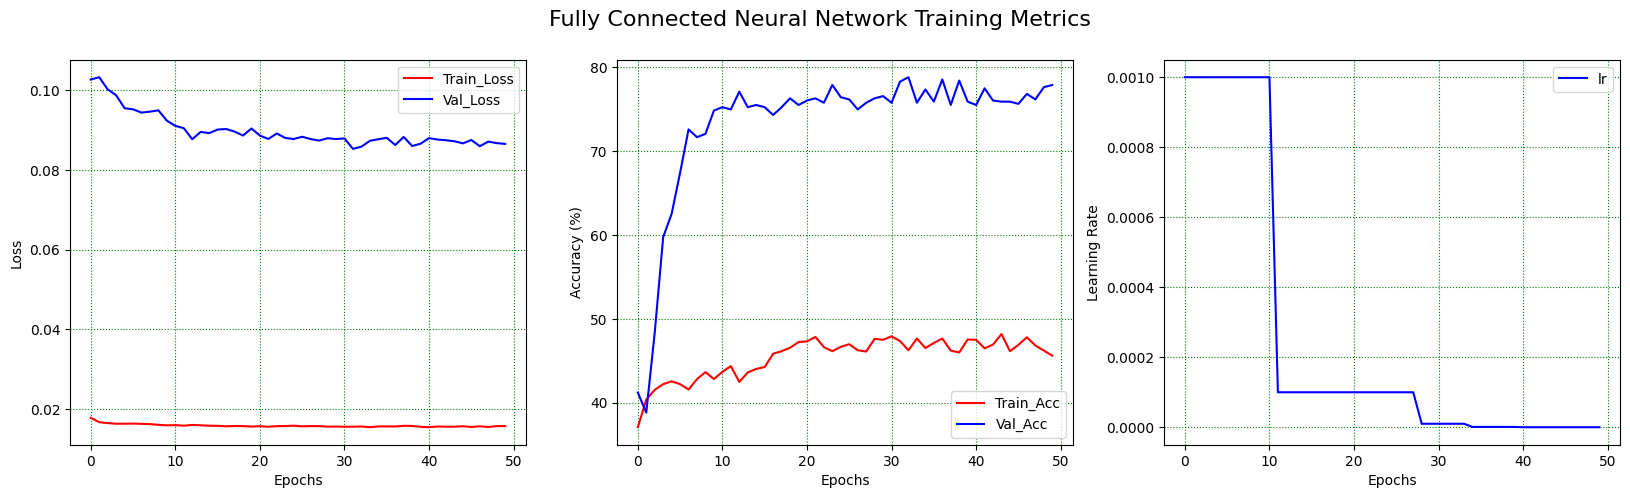

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

fc_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
fc_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
fc_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Fully Connected Neural Network Training Metrics', fontsize=16,)
plt.show()

# Custom CNN Layer - RESNet 9

In [18]:
def basic(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
  )

In [19]:
class RS_block(nn.Module):
  def __init__(self, in_channels, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, in_channels),
        basic(in_channels, in_channels),
    )

  def forward(self, x):
    return x + self.net(x)

In [20]:
class ResNet9(nn.Module):

  def __init__(self, in_channels=img_channels, num_classes=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, 64),
        basic(64, 128), nn.MaxPool2d(2),
        RS_block(128),
        basic(128, 256), nn.MaxPool2d(2),
        basic(256, 512), nn.MaxPool2d(2),
        RS_block(512),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    output = self.net(x)
    return output

In [21]:
model = ResNet9().cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [22]:
my_cnn = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="my_cnn")

Epoch 1


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.86it/s]


Training Loss = 0.3676264, Training Accuracy = 85.757
Testing Loss = 1.1914109, Testing Accuracy = 62.649
New best accuracy: 62.649 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.83it/s]


Training Loss = 0.1674796, Training Accuracy = 94.258
Testing Loss = 0.2952269, Testing Accuracy = 86.887
New best accuracy: 86.887 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.91it/s]


Training Loss = 0.1196422, Training Accuracy = 95.769
Testing Loss = 2.7302212, Testing Accuracy = 60.795
**************************************************

Epoch 4


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.03it/s]


Training Loss = 0.0888291, Training Accuracy = 96.713
Testing Loss = 0.0695234, Testing Accuracy = 97.086
New best accuracy: 97.086 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.81it/s]


Training Loss = 0.0661752, Training Accuracy = 97.393
Testing Loss = 0.6036015, Testing Accuracy = 82.781
**************************************************

Epoch 6


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.99it/s]


Training Loss = 0.0666097, Training Accuracy = 97.393
Testing Loss = 0.0907346, Testing Accuracy = 96.159
**************************************************

Epoch 7


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.73it/s]


Training Loss = 0.0747450, Training Accuracy = 97.053
Testing Loss = 0.4275854, Testing Accuracy = 85.563
**************************************************

Epoch 8


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.02it/s]


Training Loss = 0.0707804, Training Accuracy = 97.507
Testing Loss = 0.1143861, Testing Accuracy = 95.894
**************************************************

Epoch 9


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.13it/s]


Training Loss = 0.0335449, Training Accuracy = 98.942
Testing Loss = 0.1793262, Testing Accuracy = 93.377
**************************************************

Epoch 10


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.10it/s]


Training Loss = 0.0447057, Training Accuracy = 98.338
Testing Loss = 0.0443548, Testing Accuracy = 98.543
New best accuracy: 98.543 at epoch 10
**************************************************

Epoch 11


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.93it/s]


Training Loss = 0.0515233, Training Accuracy = 98.224
Testing Loss = 0.0778269, Testing Accuracy = 96.689
**************************************************

Epoch 12


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.98it/s]


Training Loss = 0.0304595, Training Accuracy = 98.829
Testing Loss = 0.0184748, Testing Accuracy = 99.470
New best accuracy: 99.470 at epoch 12
**************************************************

Epoch 13


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.92it/s]


Training Loss = 0.0182933, Training Accuracy = 99.471
Testing Loss = 0.0188702, Testing Accuracy = 99.338
**************************************************

Epoch 14


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.93it/s]


Training Loss = 0.0201598, Training Accuracy = 99.320
Testing Loss = 0.0173324, Testing Accuracy = 99.338
**************************************************

Epoch 15


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.03it/s]


Training Loss = 0.0145747, Training Accuracy = 99.471
Testing Loss = 0.0174584, Testing Accuracy = 99.205
**************************************************

Epoch 16


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.78it/s]


Training Loss = 0.0152587, Training Accuracy = 99.660
Testing Loss = 0.0212368, Testing Accuracy = 99.205
**************************************************

Epoch 17


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.88it/s]


Training Loss = 0.0133665, Training Accuracy = 99.547
Testing Loss = 0.0142997, Testing Accuracy = 99.470
**************************************************

Epoch 18


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.65it/s]


Training Loss = 0.0152929, Training Accuracy = 99.509
Testing Loss = 0.0146289, Testing Accuracy = 99.470
**************************************************

Epoch 19


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.91it/s]


Training Loss = 0.0192078, Training Accuracy = 99.358
Testing Loss = 0.0187574, Testing Accuracy = 99.073
**************************************************

Epoch 20


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.88it/s]


Training Loss = 0.0140564, Training Accuracy = 99.471
Testing Loss = 0.0125045, Testing Accuracy = 99.735
New best accuracy: 99.735 at epoch 20
**************************************************

Epoch 21


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.91it/s]


Training Loss = 0.0176285, Training Accuracy = 99.433
Testing Loss = 0.0154962, Testing Accuracy = 99.338
**************************************************

Epoch 22


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.04it/s]


Training Loss = 0.0120640, Training Accuracy = 99.660
Testing Loss = 0.0122032, Testing Accuracy = 99.470
**************************************************

Epoch 23


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.06it/s]


Training Loss = 0.0123473, Training Accuracy = 99.622
Testing Loss = 0.0185801, Testing Accuracy = 99.470
**************************************************

Epoch 24


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.97it/s]


Training Loss = 0.0118610, Training Accuracy = 99.622
Testing Loss = 0.0111980, Testing Accuracy = 99.603
**************************************************

Epoch 25


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.82it/s]


Training Loss = 0.0116981, Training Accuracy = 99.698
Testing Loss = 0.0118494, Testing Accuracy = 99.603
**************************************************

Epoch 26


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.92it/s]


Training Loss = 0.0115649, Training Accuracy = 99.584
Testing Loss = 0.0111647, Testing Accuracy = 99.603
**************************************************

Epoch 27


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.91it/s]


Training Loss = 0.0099227, Training Accuracy = 99.660
Testing Loss = 0.0105028, Testing Accuracy = 99.603
**************************************************

Epoch 28


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.86it/s]


Training Loss = 0.0087661, Training Accuracy = 99.773
Testing Loss = 0.0102909, Testing Accuracy = 99.603
**************************************************

Epoch 29


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.82it/s]


Training Loss = 0.0109859, Training Accuracy = 99.698
Testing Loss = 0.0099556, Testing Accuracy = 99.603
**************************************************

Epoch 30


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.96it/s]


Training Loss = 0.0106454, Training Accuracy = 99.660
Testing Loss = 0.0105912, Testing Accuracy = 99.603
**************************************************

Epoch 31


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.89it/s]


Training Loss = 0.0099010, Training Accuracy = 99.622
Testing Loss = 0.0102463, Testing Accuracy = 99.603
**************************************************

Epoch 32


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.96it/s]


Training Loss = 0.0099496, Training Accuracy = 99.622
Testing Loss = 0.0106060, Testing Accuracy = 99.603
**************************************************

Epoch 33


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.87it/s]


Training Loss = 0.0105522, Training Accuracy = 99.622
Testing Loss = 0.0106304, Testing Accuracy = 99.603
**************************************************

Epoch 34


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.08it/s]


Training Loss = 0.0091089, Training Accuracy = 99.622
Testing Loss = 0.0103140, Testing Accuracy = 99.603
**************************************************

Epoch 35


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.07it/s]


Training Loss = 0.0106455, Training Accuracy = 99.660
Testing Loss = 0.0107994, Testing Accuracy = 99.603
**************************************************

Epoch 36


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.25it/s]


Training Loss = 0.0096884, Training Accuracy = 99.736
Testing Loss = 0.0119255, Testing Accuracy = 99.603
**************************************************

Epoch 37


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.02it/s]


Training Loss = 0.0109268, Training Accuracy = 99.622
Testing Loss = 0.0103634, Testing Accuracy = 99.603
**************************************************

Epoch 38


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.25it/s]


Training Loss = 0.0093181, Training Accuracy = 99.736
Testing Loss = 0.0102002, Testing Accuracy = 99.603
**************************************************

Epoch 39


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.18it/s]


Training Loss = 0.0100818, Training Accuracy = 99.698
Testing Loss = 0.0107729, Testing Accuracy = 99.603
**************************************************

Epoch 40


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.22it/s]


Training Loss = 0.0074561, Training Accuracy = 99.849
Testing Loss = 0.0111832, Testing Accuracy = 99.603
**************************************************

Epoch 41


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.87it/s]


Training Loss = 0.0097844, Training Accuracy = 99.736
Testing Loss = 0.0103805, Testing Accuracy = 99.603
**************************************************

Epoch 42


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.94it/s]


Training Loss = 0.0097844, Training Accuracy = 99.698
Testing Loss = 0.0111894, Testing Accuracy = 99.603
**************************************************

Epoch 43


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.88it/s]


Training Loss = 0.0094272, Training Accuracy = 99.622
Testing Loss = 0.0125709, Testing Accuracy = 99.603
**************************************************

Epoch 44


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.90it/s]


Training Loss = 0.0114911, Training Accuracy = 99.660
Testing Loss = 0.0112253, Testing Accuracy = 99.603
**************************************************

Epoch 45


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.80it/s]


Training Loss = 0.0112073, Training Accuracy = 99.698
Testing Loss = 0.0108617, Testing Accuracy = 99.603
**************************************************

Epoch 46


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.53it/s]


Training Loss = 0.0094536, Training Accuracy = 99.698
Testing Loss = 0.0105269, Testing Accuracy = 99.603
**************************************************

Epoch 47


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.78it/s]


Training Loss = 0.0094111, Training Accuracy = 99.811
Testing Loss = 0.0118177, Testing Accuracy = 99.735
**************************************************

Epoch 48


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.79it/s]


Training Loss = 0.0083952, Training Accuracy = 99.736
Testing Loss = 0.0113012, Testing Accuracy = 99.603
**************************************************

Epoch 49


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.64it/s]


Training Loss = 0.0094087, Training Accuracy = 99.811
Testing Loss = 0.0099757, Testing Accuracy = 99.603
**************************************************

Epoch 50


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.98it/s]

Training Loss = 0.0127983, Training Accuracy = 99.547
Testing Loss = 0.0105312, Testing Accuracy = 99.603
**************************************************



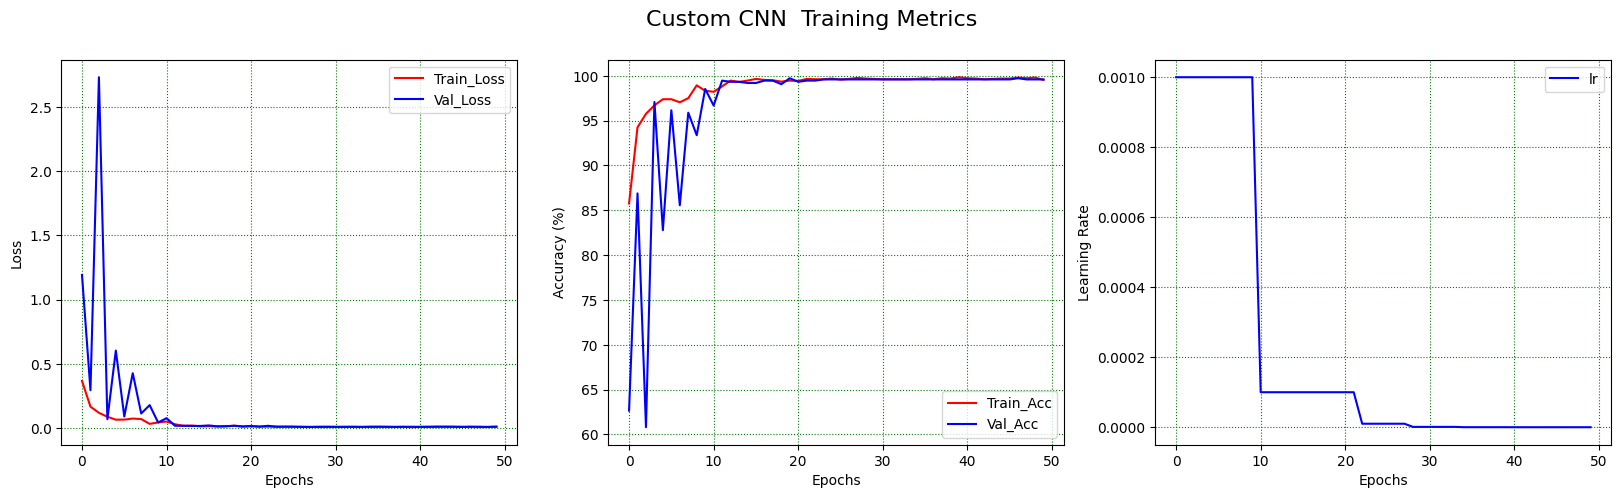

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

my_cnn.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
my_cnn.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
my_cnn.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Transfer Learning

In [24]:
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 181MB/s]


In [25]:
model.eval()

for params in model.parameters():
  params.requires_grad = False

In [26]:
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 3)

In [27]:
model = model.cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [28]:
transfer_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=20, experiment_name="tranfer")

Epoch 1


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.03it/s]


Training Loss = 0.5808492, Training Accuracy = 78.920
Testing Loss = 0.2502943, Testing Accuracy = 94.834
New best accuracy: 94.834 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.05it/s]


Training Loss = 0.1988877, Training Accuracy = 94.938
Testing Loss = 0.1388103, Testing Accuracy = 97.881
New best accuracy: 97.881 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.08it/s]


Training Loss = 0.1346972, Training Accuracy = 96.411
Testing Loss = 0.0920644, Testing Accuracy = 98.278
New best accuracy: 98.278 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.07it/s]


Training Loss = 0.1037624, Training Accuracy = 96.978
Testing Loss = 0.0827601, Testing Accuracy = 97.616
**************************************************

Epoch 5


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.04it/s]


Training Loss = 0.0886146, Training Accuracy = 97.658
Testing Loss = 0.0672890, Testing Accuracy = 98.278
**************************************************

Epoch 6


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.16it/s]


Training Loss = 0.0746871, Training Accuracy = 97.771
Testing Loss = 0.0639993, Testing Accuracy = 98.278
**************************************************

Epoch 7


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.17it/s]


Training Loss = 0.0730383, Training Accuracy = 97.809
Testing Loss = 0.0504116, Testing Accuracy = 98.808
New best accuracy: 98.808 at epoch 7
**************************************************

Epoch 8


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.08it/s]


Training Loss = 0.0677788, Training Accuracy = 98.036
Testing Loss = 0.0383644, Testing Accuracy = 99.205
New best accuracy: 99.205 at epoch 8
**************************************************

Epoch 9


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.98it/s]


Training Loss = 0.0568027, Training Accuracy = 98.602
Testing Loss = 0.0653573, Testing Accuracy = 98.013
**************************************************

Epoch 10


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.15it/s]


Training Loss = 0.0516059, Training Accuracy = 98.602
Testing Loss = 0.0374929, Testing Accuracy = 99.205
**************************************************

Epoch 11


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.06it/s]


Training Loss = 0.0400636, Training Accuracy = 98.980
Testing Loss = 0.0268923, Testing Accuracy = 99.205
**************************************************

Epoch 12


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.03it/s]


Training Loss = 0.0459140, Training Accuracy = 98.376
Testing Loss = 0.0257175, Testing Accuracy = 99.205
**************************************************

Epoch 13


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.97it/s]


Training Loss = 0.0379569, Training Accuracy = 98.753
Testing Loss = 0.0275920, Testing Accuracy = 99.205
**************************************************

Epoch 14


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.07it/s]


Training Loss = 0.0379943, Training Accuracy = 98.753
Testing Loss = 0.0223188, Testing Accuracy = 99.205
**************************************************

Epoch 15


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.11it/s]


Training Loss = 0.0391727, Training Accuracy = 98.716
Testing Loss = 0.0286066, Testing Accuracy = 99.205
**************************************************

Epoch 16


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  6.91it/s]


Training Loss = 0.0433233, Training Accuracy = 98.413
Testing Loss = 0.0524746, Testing Accuracy = 98.146
**************************************************

Epoch 17


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.05it/s]


Training Loss = 0.0622246, Training Accuracy = 97.658
Testing Loss = 0.0265723, Testing Accuracy = 99.338
New best accuracy: 99.338 at epoch 17
**************************************************

Epoch 18


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.17it/s]


Training Loss = 0.0333017, Training Accuracy = 98.867
Testing Loss = 0.0207012, Testing Accuracy = 99.470
New best accuracy: 99.470 at epoch 18
**************************************************

Epoch 19


Evaluating: 100%|██████████| 76/76 [00:11<00:00,  6.69it/s]


Training Loss = 0.0307376, Training Accuracy = 99.018
Testing Loss = 0.0228009, Testing Accuracy = 99.868
New best accuracy: 99.868 at epoch 19
**************************************************

Epoch 20


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.26it/s]

Training Loss = 0.0250482, Training Accuracy = 99.207
Testing Loss = 0.0322922, Testing Accuracy = 98.808
**************************************************



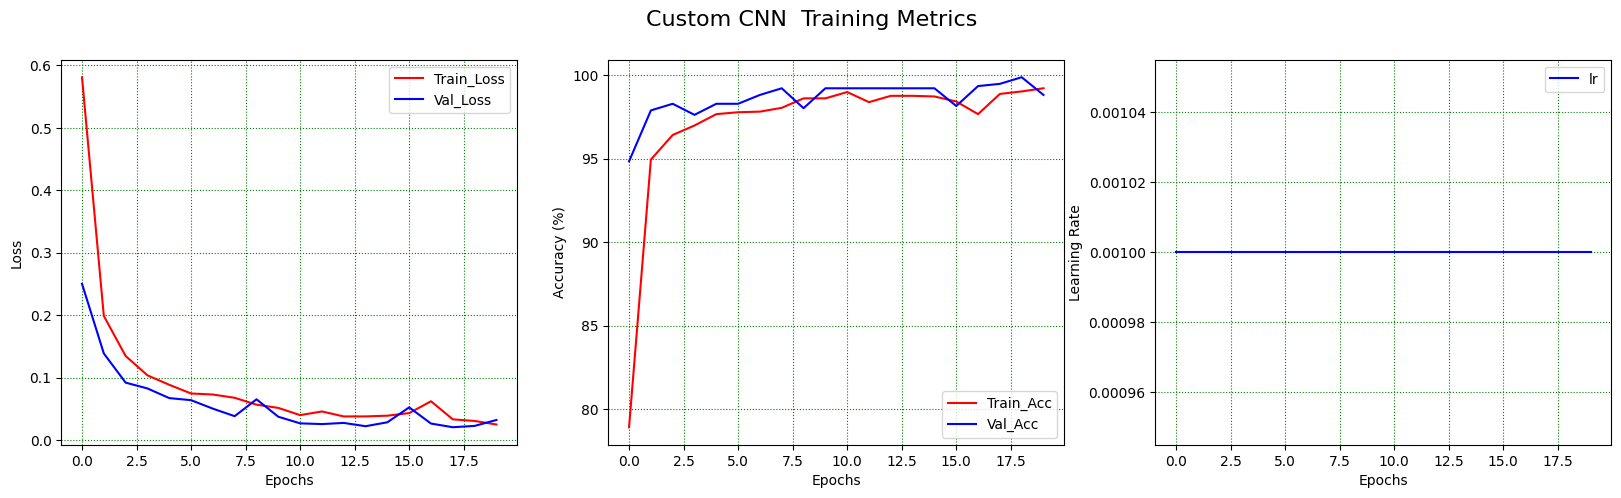

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

transfer_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
transfer_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
transfer_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Model Inferences